## Setup libraries

In [1]:
from PIL import Image, ImageDraw
import pydicom

from fastai.data.all import *

In [2]:
def get_dicom_files(path, recurse=True, folders=None):
    "Get dicom files in `path` recursively, only in `folders`, if specified."
    return get_files(path, extensions=[".dcm",".dicom"], recurse=recurse, folders=folders)

## Get Data

In [3]:
in_path = Path('src')
out_path = Path('/media/veracrypt1/Data Science/SIIM-Imgs/png')

stage = 'test'

In [4]:
filenames = get_dicom_files(in_path / stage)

Check single file

In [5]:
fn = filenames[0]

In [6]:
arr = pydicom.read_file(fn).pixel_array
img = Image.fromarray((arr/arr.max() * 255).astype(np.uint8))

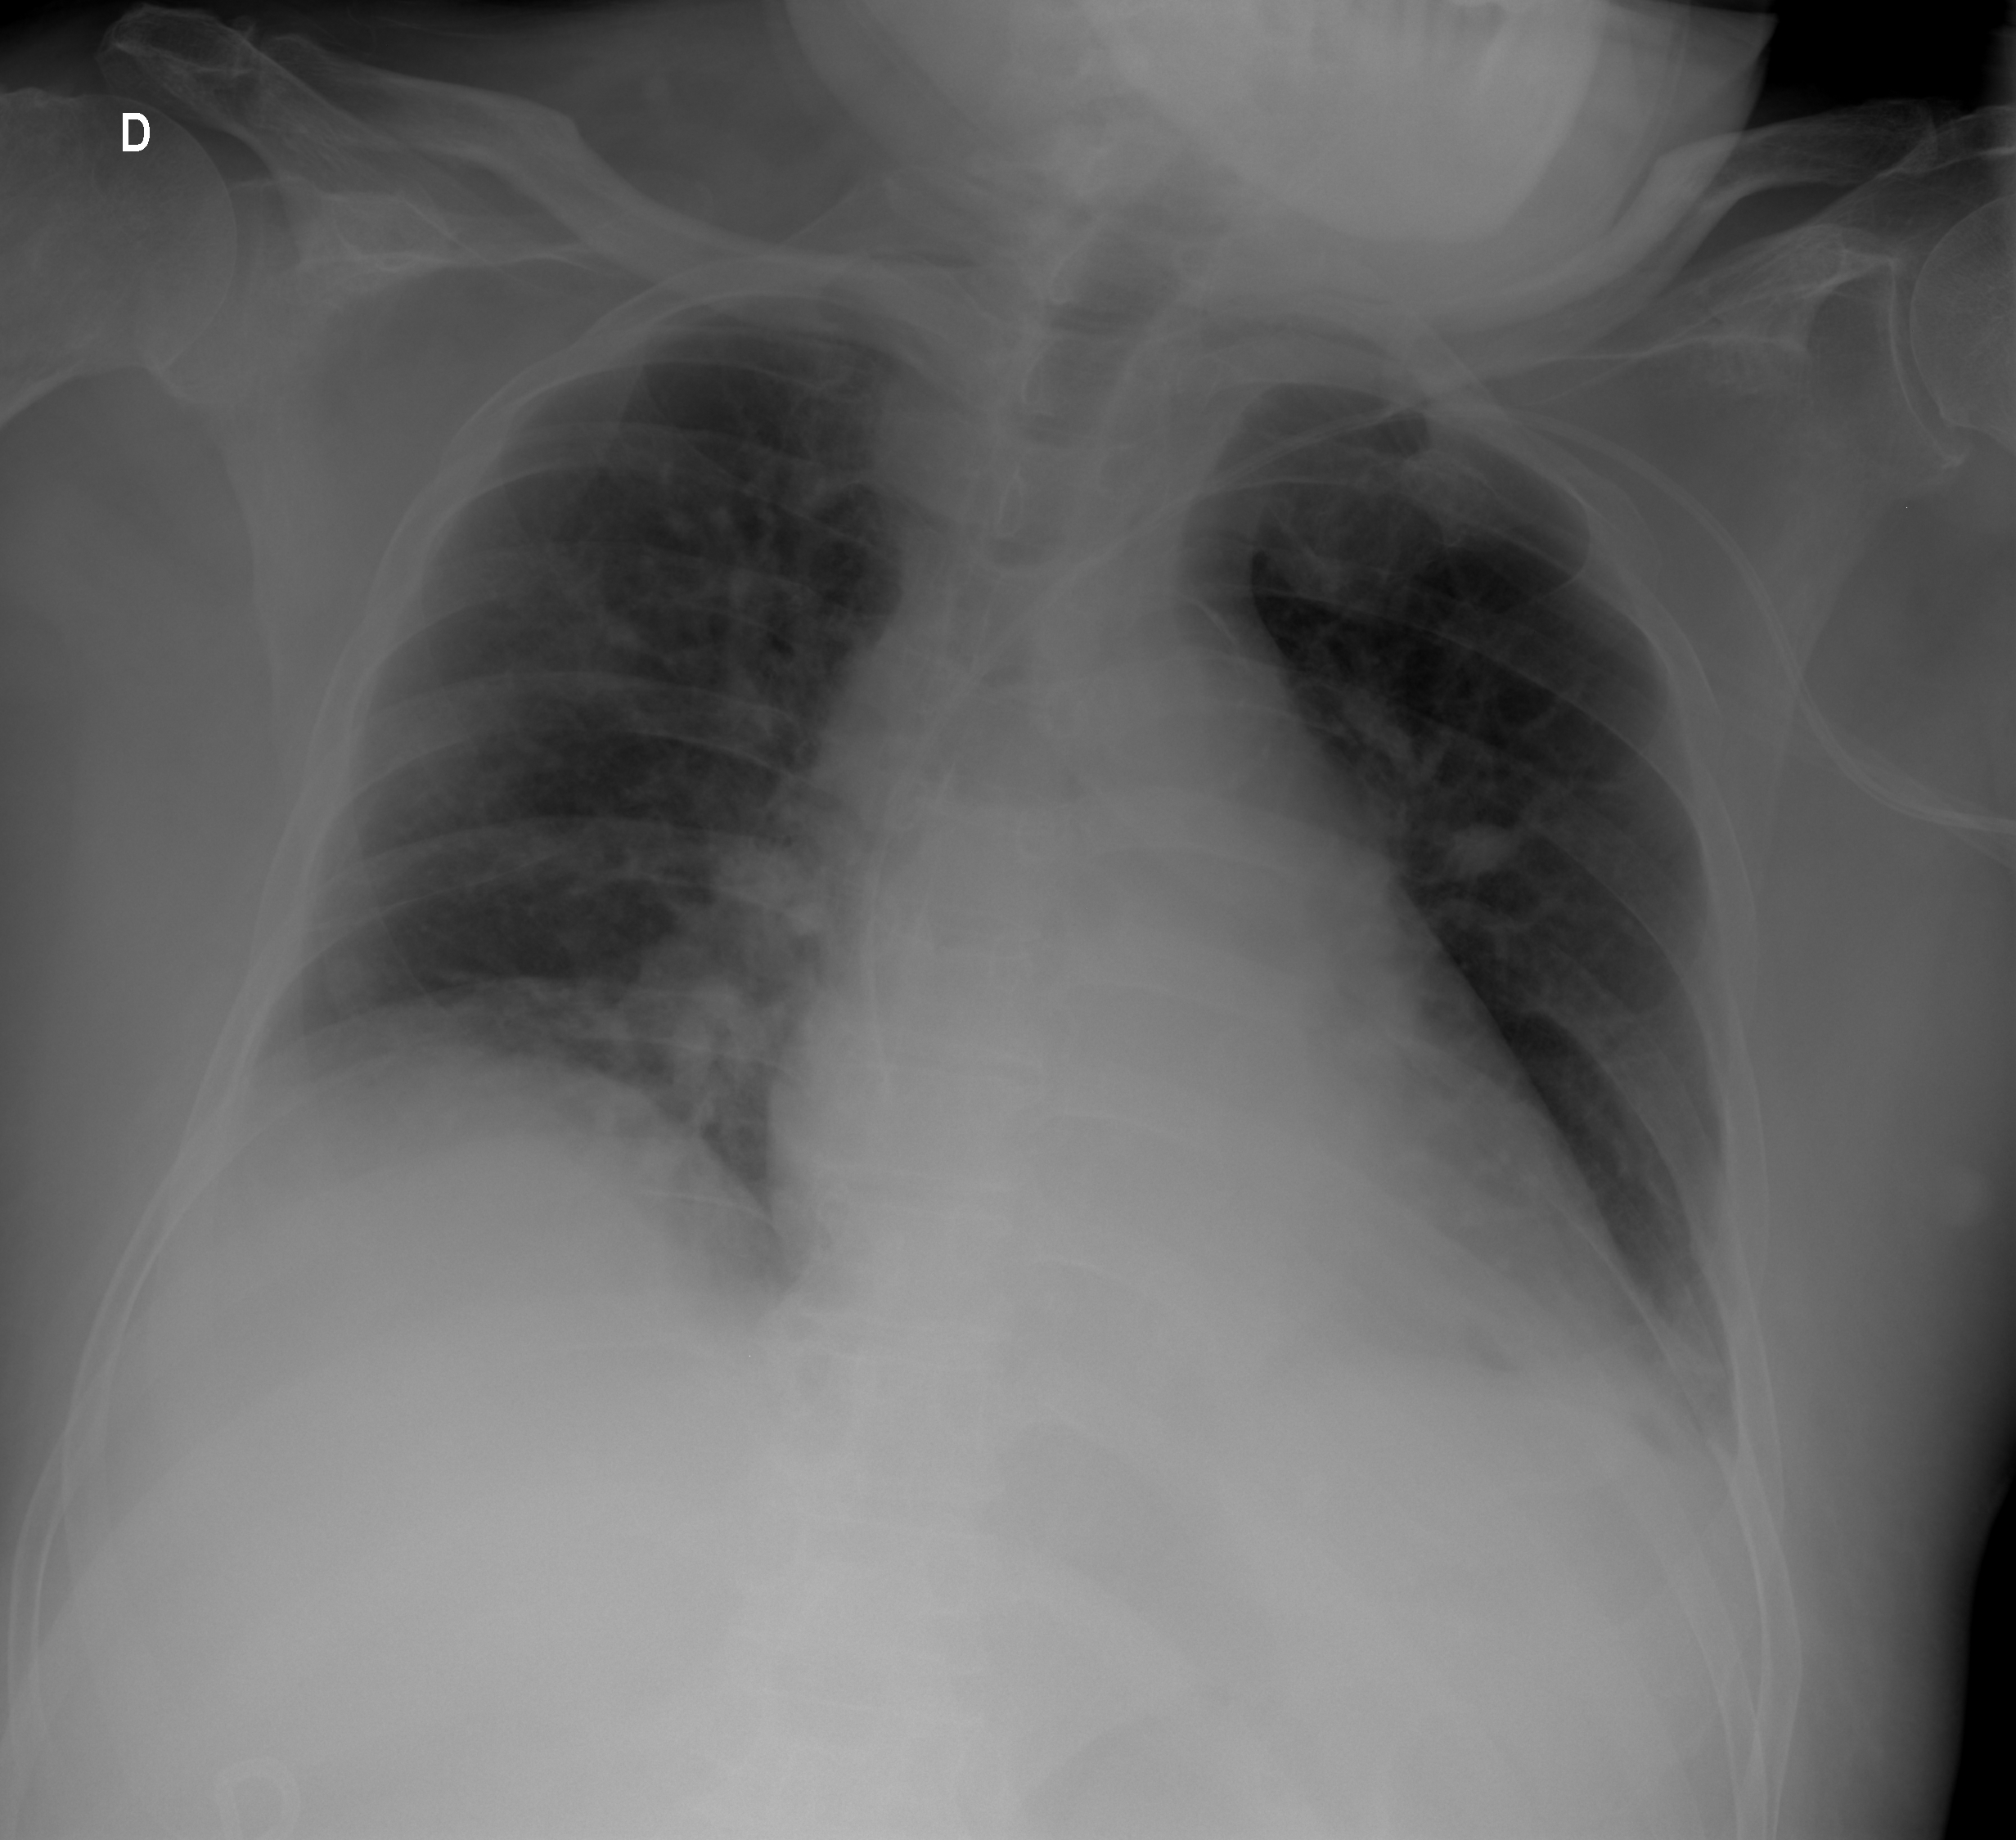

In [7]:
img

## Get the resize scalar from the image

In [11]:
def set_scalar(fn, new_width = 1024):
    width = pydicom.read_file(fn).Columns
    return new_width / width

Save images scalars to list

In [12]:
scalars = [set_scalar(fn) for fn in filenames]

Create dataframe from filenames & scalars list.

In [13]:
df = pd.DataFrame({'id': [fn.name for fn in filenames], 'scalar': scalars})

In [14]:
df.head()

,id,scalar
0,fdbaf93d6c5b.dcm,0.415584
1,c6fa6b9b8093.dcm,0.390542
2,e5e44940be7a.dcm,0.390542
3,a0f473f71878.dcm,0.361582
4,3d56a237b6be.dcm,0.300469


## Save dataframe

In [28]:
df.to_pickle(in_path / 'test_ready.pkl')

## Get scalar from dataframe

In [15]:
def get_scalar(fn):
    return df.loc[df['id'] == fn.name, 'scalar'].values[0]

## Test resize and save for single image

In [16]:
scalar = get_scalar(fn)
resized_img = img.resize((1024,int(img.height * scalar)), resample = Image.LANCZOS)

out_fn = Path(*fn.parts[1:])
folder_struct = out_fn.parent
(out_path / folder_struct).mkdir(exist_ok = True, parents = True)

resized_img.save((out_path / out_fn).with_suffix('.png'))

## Resize and save all test images

In [17]:
m = len(filenames)
print(m)
for i,fn in enumerate(filenames):
    print(f'{(i / (m-1) * 100):5.2f}%', end='\r')
    scalar = get_scalar(fn)
    
    arr = pydicom.read_file(fn).pixel_array
    img = Image.fromarray((arr/arr.max() * 255).astype(np.uint8))
    resized_img = img.resize((1024,int(img.height * scalar)), resample = Image.LANCZOS).convert('RGB')

    out_fn = Path(*fn.parts[1:])
    folder_struct = out_fn.parent
    (out_path / folder_struct).mkdir(exist_ok = True, parents = True)

    resized_img.save((out_path / out_fn).with_suffix('.png'))

1263


## Sanity check

In [25]:
new_imgs = get_files(out_path/stage)
assert(len(new_imgs) == len(filenames))